The purpose of the notebook is to train a graph network for predicting the shortest path between two nodes in graph.

The network is trained to label the nodes and the edges of the shortest path, given the start and the end nodes.

Geographical thresholded graph

the geographical threshold graph model places n nodes uniformly at random in a rectangular domain. Each node u is assigned a weight w_u. Two nodes u and v are joined by an edge if

$$
w_u+w_v\gt \theta \ r^{\alpha}
$$

where r is the Euclidean distance between u and v and $\theta$, $\alpha$ are parameters.


In [1]:
import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos_tf2 import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import random as rand

SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [4]:
DISTANCE_WEIGHT_NAME = "distance"  # The name for the distance edge attribute.


def pairwise(iterable):
  """s -> (s0,s1), (s1,s2), (s2, s3), ..."""
  #intertools.tee returns two iterable 
  a, b = itertools.tee(iterable)
  next(b, None)
  return zip(a, b)

def set_diff(seq0, seq1):
  """Return the set difference between 2 sequences as a list."""
  return list(set(seq0) - set(seq1))

def to_one_hot(indices, max_value, axis=-1):
  one_hot = np.eye(max_value)[indices]
  if axis not in (-1, one_hot.ndim):
    one_hot = np.moveaxis(one_hot, -1, axis)
  return one_hot

def get_node_dict(graph, attr):
  """Return a `dict` of node:attribute pairs from a graph."""
  return {k: v[attr] for k, v in graph.nodes.items()}

def generate_graph(rand,
                   num_nodes_min_max,
                   dimensions=2,
                   theta=1000.0,
                   rate=1.0):
  """Creates a connected graph.

  The graphs are geographic threshold graphs, but with added edges via a
  minimum spanning tree algorithm, to ensure all nodes are connected.

  Args:
    rand: A random seed for the graph generator. Default= None.
    num_nodes_min_max: A sequence [lower, upper) number of nodes per graph.
    dimensions: (optional) An `int` number of dimensions for the positions.
      Default= 2.
    theta: (optional) A `float` threshold parameters for the geographic
      threshold graph's threshold. Large values (1000+) make mostly trees. Try
      20-60 for good non-trees. Default=1000.0.
    rate: (optional) A rate parameter for the node weight exponential sampling
      distribution. Default= 1.0.

  Returns:
    The graph.
  """
  # Sample num_nodes.
  num_nodes = rand.randint(*num_nodes_min_max)

  # Create geographic threshold graph.
  #pos_array returns the position of the node in the rectangular domain
  pos_array = rand.uniform(size=(num_nodes, dimensions))
  #pos contains the node and the position in the rectangular domain
  pos = dict(enumerate(pos_array))
  #weight contains the node and the weight sampled from an exponential distribution
  weight = dict(enumerate(rand.exponential(rate, size=num_nodes)))

  geo_graph = nx.geographical_threshold_graph(
      num_nodes, theta, pos=pos, weight=weight)

  # Create minimum spanning tree across geo_graph's nodes.
  distances = spatial.distance.squareform(spatial.distance.pdist(pos_array))
  i_, j_ = np.meshgrid(range(num_nodes), range(num_nodes), indexing="ij")
  weighted_edges = list(zip(i_.ravel(), j_.ravel(), distances.ravel()))
  mst_graph = nx.Graph()
  mst_graph.add_weighted_edges_from(weighted_edges, weight=DISTANCE_WEIGHT_NAME)
  mst_graph = nx.minimum_spanning_tree(mst_graph, weight=DISTANCE_WEIGHT_NAME)
  # Put geo_graph's node attributes into the mst_graph.
  for i in mst_graph.nodes():
    mst_graph.nodes[i].update(geo_graph.nodes[i])

  # Compose the graphs.
  combined_graph = nx.compose_all((mst_graph, geo_graph.copy()))
  # Put all distance weights into edge attributes.
  for i, j in combined_graph.edges():
    combined_graph.get_edge_data(i, j).setdefault(DISTANCE_WEIGHT_NAME,
                                                  distances[i, j])
  return combined_graph, mst_graph, geo_graph


In [3]:
rand = np.random.RandomState(seed=1)

In [5]:
pos_array = rand.uniform(size=(10, 2))

In [6]:
pos_array

array([[4.17022005e-01, 7.20324493e-01],
       [1.14374817e-04, 3.02332573e-01],
       [1.46755891e-01, 9.23385948e-02],
       [1.86260211e-01, 3.45560727e-01],
       [3.96767474e-01, 5.38816734e-01],
       [4.19194514e-01, 6.85219500e-01],
       [2.04452250e-01, 8.78117436e-01],
       [2.73875932e-02, 6.70467510e-01],
       [4.17304802e-01, 5.58689828e-01],
       [1.40386939e-01, 1.98101489e-01]])

In [7]:
pos = dict(enumerate(pos_array))

In [8]:
pos

{0: array([0.417022  , 0.72032449]),
 1: array([1.14374817e-04, 3.02332573e-01]),
 2: array([0.14675589, 0.09233859]),
 3: array([0.18626021, 0.34556073]),
 4: array([0.39676747, 0.53881673]),
 5: array([0.41919451, 0.6852195 ]),
 6: array([0.20445225, 0.87811744]),
 7: array([0.02738759, 0.67046751]),
 8: array([0.4173048 , 0.55868983]),
 9: array([0.14038694, 0.19810149])}

In [9]:
weight = dict(enumerate(rand.exponential(1, size=10)))

In [10]:
weight

{0: 1.6131677028403504,
 1: 3.4502272097097024,
 2: 0.37603861290897017,
 3: 1.1787034984431248,
 4: 2.090616973214474,
 5: 2.250055865972534,
 6: 0.08887953331090477,
 7: 0.03983787812260575,
 8: 0.18612528528308295,
 9: 2.1049029778605255}

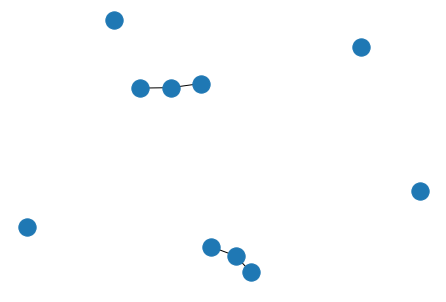

In [16]:
G = nx.geographical_threshold_graph(10, 50)
nx.draw(G)